# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy.io import loadmat
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"

# Problem Statement

The goal is to solve the 2D boundary value problem of linear elasiticity using neural networks. The PDE is defined as follows:
$$
\begin{align}
\begin{split}
G\left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \right] + G\left( \frac{1+v}{1-v} \right) \left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2v}{\partial yx} \right] + \sin(2\pi x) \sin(2\pi y) = 0 \\
G\left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \right] + G\left( \frac{1+v}{1-v} \right) \left[\frac{\partial^2v}{\partial y^2} + \frac{\partial^2u}{\partial xy} \right] + \sin(\pi x) +  \sin(2\pi y) = 0
\end{split}
\end{align}
$$
with boundary conditions $ u, v = 0$ and
$$
G = \frac{E}{2(1+\nu)}
$$

# Solution

## The Neural Network

We will start by defining the neural network. The network will be a simple feed forward network with 5 hidden layers and 30 neurons each layer. The input to the network will be the coordinates $(x,y)$ and the output will be the displacement $u$ and $v$. `tanh` activation function will be used for the hidden layers and `linear` activation function will be used for the output layer.

In [2]:
class Displacements(nn.Module):
    def __init__(self, ns=30):
        super(Displacements, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, 2),
        )

    def forward(self, x):
        return self.net(x)

model = Displacements()
print(model)

Displacements(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): Tanh()
    (8): Linear(in_features=30, out_features=30, bias=True)
    (9): Tanh()
    (10): Linear(in_features=30, out_features=2, bias=True)
  )
)


This gives us the required network architecture. Next, we load the boundary and interior points.

## Loading the data

In [3]:
boundary_points = loadmat('boundary_points.mat')
x_boundary = boundary_points['x_bdry']
y_boundary = boundary_points['y_bdry']
assert len(x_boundary) == len(y_boundary), 'x and y boundary points must have the same length'
BOUNDARY_POINTS = len(x_boundary)
print(f'Number of boundary points: {BOUNDARY_POINTS}')

Number of boundary points: 160


In [4]:
interior_points = loadmat('interior_points.mat')
x_interior = interior_points['x']
y_interior = interior_points['y']
assert len(x_interior) == len(y_interior), 'x and y interior points must have the same length'
INTERIOR_POINTS = len(x_interior)
print(f'Number of interior points: {INTERIOR_POINTS}')

Number of interior points: 2705


Let's have a look at how the data looks like.

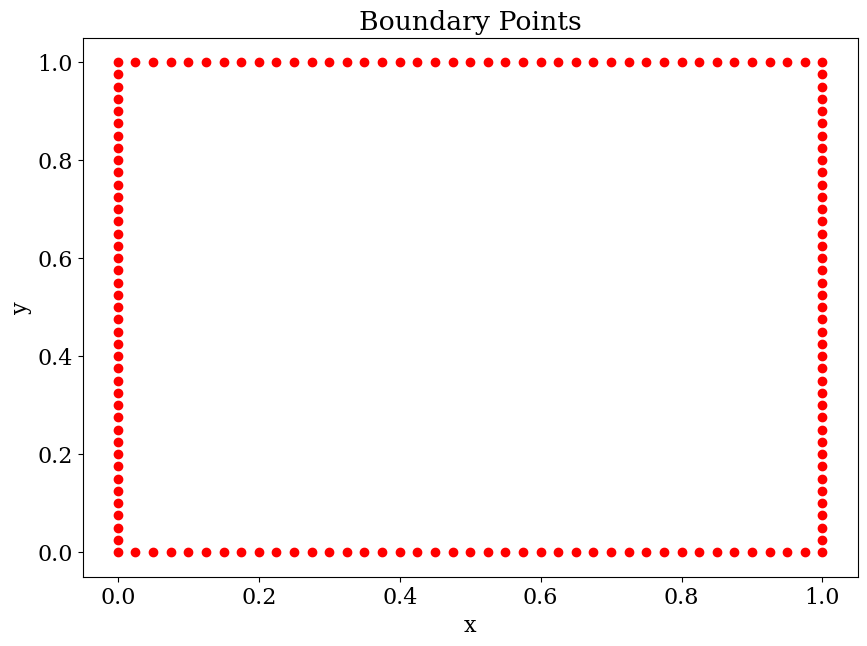

In [5]:
plt.plot(x_boundary, y_boundary, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Boundary Points')
plt.show()

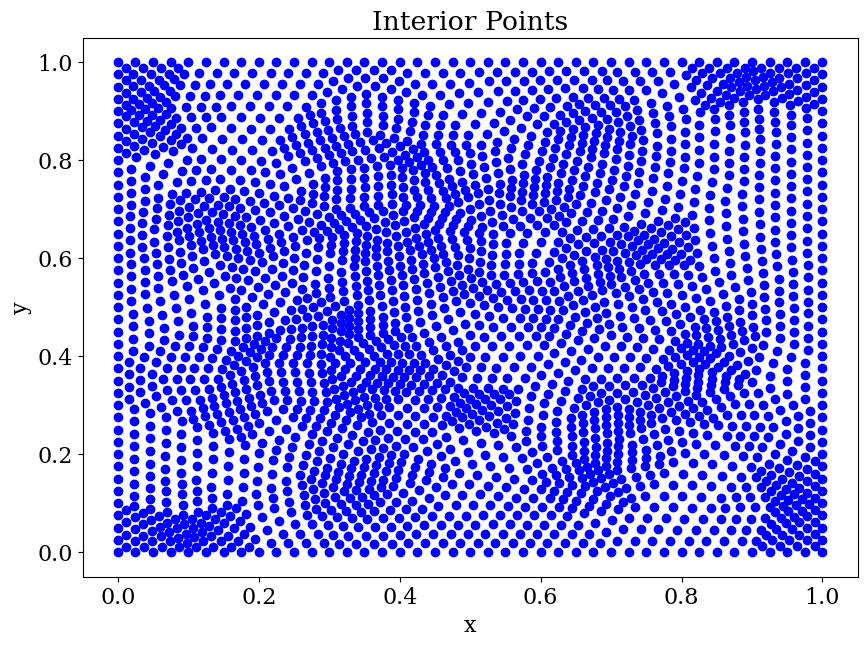

In [6]:
plt.plot(x_interior, y_interior, 'ob')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interior Points')
plt.show()

We'll need to concatenate the boundary and interior points to get the complete data. As the boundary condition is $u, v = 0$, we will also create a target array with all zeros for the boundary points.

In [7]:
X_boundary = torch.tensor(np.concatenate((x_boundary, y_boundary), axis=1), dtype=torch.float32, requires_grad=True)
X_interior = torch.tensor(np.concatenate((x_interior, y_interior), axis=1), dtype=torch.float32, requires_grad=True)

X = torch.cat((X_boundary, X_interior), dim=0)
u_boundary = torch.tensor(np.zeros((BOUNDARY_POINTS, 1)), dtype=torch.float32, requires_grad=True)
v_boundary = torch.tensor(np.zeros((BOUNDARY_POINTS, 1)), dtype=torch.float32, requires_grad=True)
U_boundary = torch.cat((u_boundary, v_boundary), dim=1)
print(X.shape, U_boundary.shape)

torch.Size([2865, 2]) torch.Size([160, 2])


This makes the data ready for training. Next, we'll create the loss function.

## Loss Function

The loss function is made up of two parts:
1. The PDE loss
2. The boundary loss

### Boundary Loss

The boundary loss will be a simple RMSE loss. Here is the code for the bounadry loss.

In [8]:
def boundary_loss(U_pred_b, U_b):
    return torch.mean((U_pred_b - U_b)**2)

### PDE Loss

The PDE loss is complicated. We first need to determine the derivatives of $u$ and $v$ with respect to $x$ and $y$. Let's see how we can do that. But first, let's define $G$. which is used in the PDE:

In [9]:
E = 1.0 # Young's modulus
nu = 0.3 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus

In [118]:
def pde_loss(X_i, model):
    """Calculate the loss for the PDE.
    
    Parameters
    ----------
    X_i : torch.Tensor
        The interior points.
    model : torch.nn.Module
        The model. It predicts the displacements for the interior points.
    
    Returns
    -------
    torch.Tensor
        The loss.
    """
    x, y = X_i[:, 0], X_i[:, 1]
    U_i = model(X_i)
    u = U_i[:, 0]
    v = U_i[:, 1]

    dudx, dudy = torch.autograd.grad(u.sum(), X_i, create_graph=True, retain_graph=True)[0].T
    dvdx, dvdy = torch.autograd.grad(v.sum(), X_i, create_graph=True, retain_graph=True)[0].T

    du2dx2, du2dxdy = torch.autograd.grad(dudx.sum(), X_i, create_graph=True, retain_graph=True)[0].T
    du2dydx, du2dy2 = torch.autograd.grad(dudy.sum(), X_i, create_graph=True, retain_graph=True)[0].T

    dv2dx2, dv2dxdy = torch.autograd.grad(dvdx.sum(), X_i, create_graph=True, retain_graph=True)[0].T
    dv2dydx, dv2dy2 = torch.autograd.grad(dvdy.sum(), X_i, create_graph=True, retain_graph=True)[0].T


    l1 = G*(du2dx2 + du2dy2) + G*((1+v)/(1-v))*(du2dx2 + dv2dydx) + torch.sin(2*torch.pi*x)*torch.sin(2*torch.pi*y)
    # t2 = G*((1+v)/(1-v))*(du2dx2 + dv2dydx)
    # t3 = torch.sin(2*torch.pi*x)*torch.sin(2*torch.pi*y)
    # loss_1 = t1 + t2 + t3

    #Calculate the second PDE loss
    l2 = G*(dv2dx2 + dv2dy2) + G*((1+v)/(1-v))*(du2dydx + dv2dy2) + torch.sin(torch.pi*x) + torch.sin(2*torch.pi*y)
    # t2 = G*((1+v)/(1-v))*(du2dxdy + dv2dy2)
    # t3 = torch.sin(torch.pi*x) + torch.sin(2*torch.pi*y)
    # loss_2 = t1 + t2 + t3

    #total pde loss
    loss_pde = torch.mean(l1**2) + torch.mean(l2**2)
    return loss_pde

### Total Loss

Now, the total loss:

In [119]:
pde_losses = []
boundary_losses = []
total_losses = []
def loss(model, epoch, frequency):
    """Calculate the total loss.
    
    args:
        model: The model.
        epoch: The current epoch.
        frequency: The number of epochs between each print.
    """
    l_pde = pde_loss(X_interior, model)
    l_b = boundary_loss(model(X_boundary), U_boundary)
    l_total = l_pde + l_b
    pde_losses.append(l_pde.item())
    boundary_losses.append(l_b.item())
    total_losses.append(l_total.item())
    if frequency == 0:
        return l_total
    if ((epoch +1 ) % frequency == 0):
        print(f"Epoch {epoch:>3d}: PDE loss: {l_pde.item():.4f}  Boundary loss: {l_b.item():.4f} Total loss: {l_total.item():.4f}")
    return l_total

Excellent! We have the loss function ready. Next, we'll create the optimizer and train the model.

## Training

In [120]:
model = Displacements()

In [121]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=100, max_eval=100, tolerance_grad=1e-05, tolerance_change=1e-06)
for epoch in range(40):
    optimizer.zero_grad()
    l = loss(model, epoch, 2)
    l.backward()
    def closure():
        optimizer.zero_grad()
        loss_ = loss(model, epoch, 0)
        loss_.backward()
        return loss_
    optimizer.step(closure)

Epoch   1: PDE loss: 0.1479  Boundary loss: 0.0265 Total loss: 0.1744
Epoch   3: PDE loss: 0.0067  Boundary loss: 0.0032 Total loss: 0.0100
Epoch   5: PDE loss: 0.0025  Boundary loss: 0.0010 Total loss: 0.0035
Epoch   7: PDE loss: 0.0011  Boundary loss: 0.0005 Total loss: 0.0016
Epoch   9: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  11: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  13: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  15: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  17: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  19: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  21: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  23: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  25: PDE loss: 0.0005  Boundary loss: 0.0002 Total loss: 0.0007
Epoch  27: PDE loss: 0.0005  Boundary loss: 0.0001 Total loss: 0.0007
Epoch  29: PDE loss:

Let's save the model:

In [113]:
torch.save(model.state_dict(), 'model.pt')

## Results

Now, we'll plot the results. We will use 300 points for plotting the results. First, we need to create a meshgrid:

In [122]:
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 150))
X_to_predict = torch.tensor(np.concatenate((x_mesh.reshape(-1, 1), y_mesh.reshape(-1, 1)), axis=1), dtype=torch.float32, requires_grad=True)
X_to_predict.shape

torch.Size([22500, 2])

Next, predict the values for the meshgrid:

In [123]:
U_pred = model(X_to_predict)
u_pred = U_pred[:, 0].detach().numpy()
u_pred = u_pred.reshape(x_mesh.shape)
v_pred = U_pred[:, 1].detach().numpy()
v_pred = v_pred.reshape(x_mesh.shape)

Now, we can plot the results:

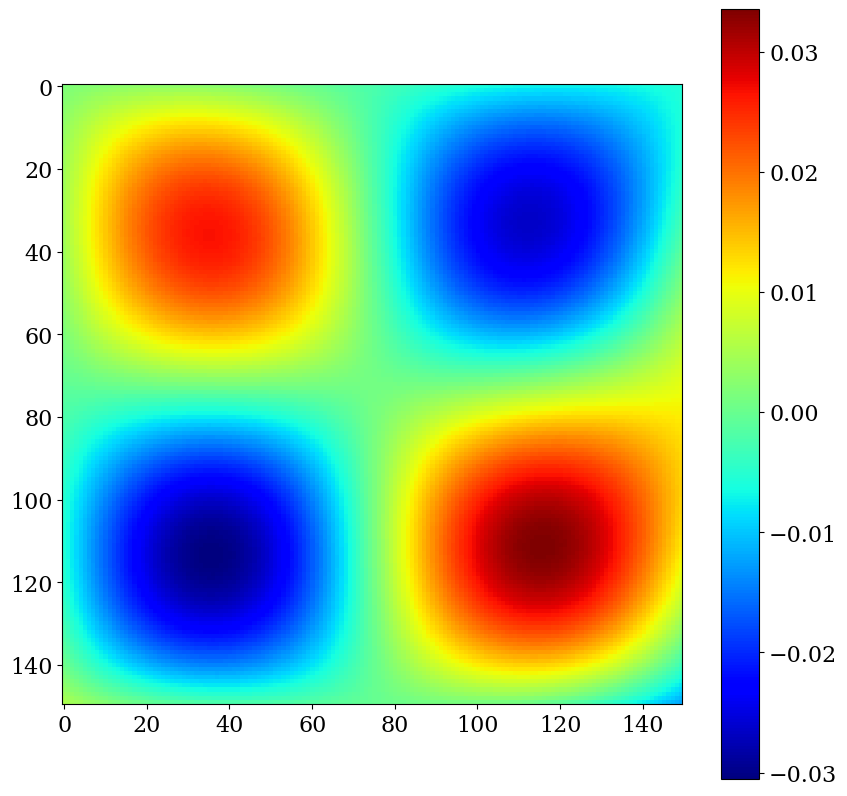

In [124]:
#plot image
plt.figure(figsize=(10, 10))
plt.imshow(u_pred, cmap='jet')
plt.colorbar()

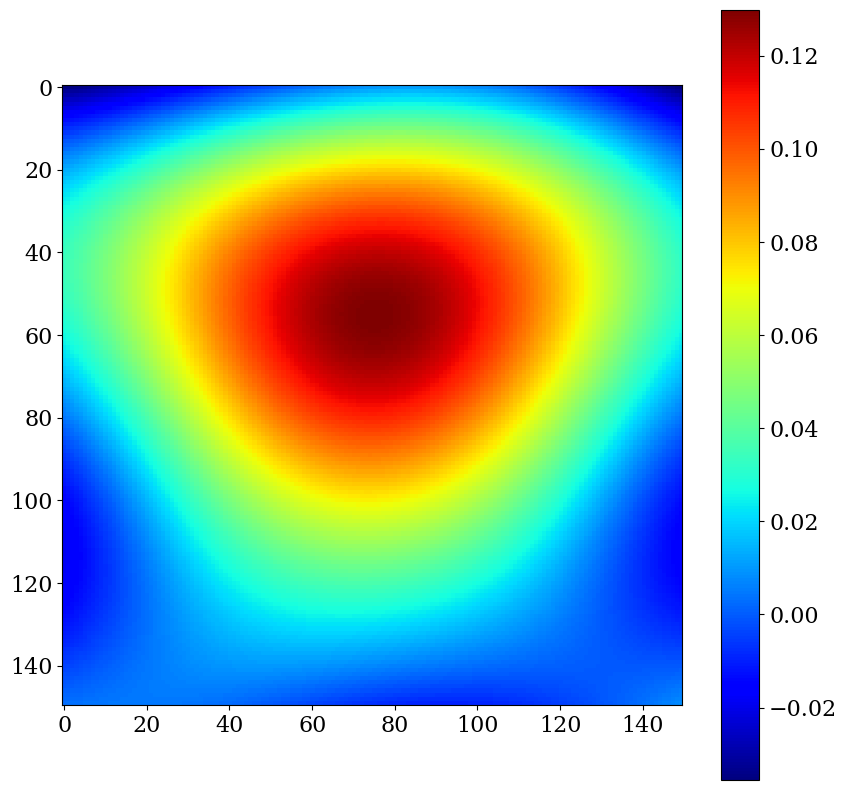

In [125]:
#plot image
plt.figure(figsize=(10, 10))
plt.imshow(v_pred, cmap='jet')
plt.colorbar()

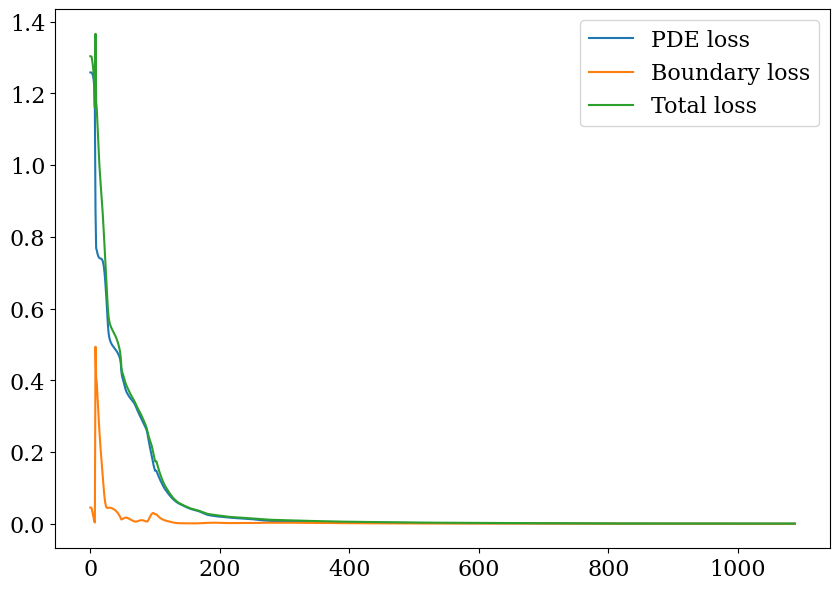

In [126]:
plt.plot(pde_losses, label='PDE loss')
plt.plot(boundary_losses, label='Boundary loss')
plt.plot(total_losses, label='Total loss')
plt.legend()
plt.show()